# Data Import and Downloads

In [29]:
!unzip archive.zip
!pip install ultralytics==8.0.196
!pip install pyyaml

Archive:  archive.zip
replace TEST/images/d_r_122_.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.7 MB/s eta 0:00:00
  Attempting uninstall: nv

#Importing Modules

In [19]:
import os
import random
import json
import torch
import torchvision.transforms.functional as F
from torchvision.ops import masks_to_boxes
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image
import cv2
from collections import Counter, defaultdict
import pandas as pd
from pathlib import Path
import shutil
import yaml
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Setting Seed

In [3]:
def set_seed(seed_value):
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

set_seed(2)

# File Paths and Class Definitions

In [4]:
train_val_dir = "/content/train_val"
test_dir = "/content/TEST"

train_path = Path(train_val_dir)
test_path = Path(test_dir)
train_images_path = train_path / "images"
train_masks_path = train_path / "masks"
test_images_path = test_path / "images"
test_masks_path = test_path / "masks"

class_colors = {
    'BW': [0, 0, 0],           # Background/waterbody (Black)
    'HD': [0, 0, 255],         # Human divers (Blue)
    'PF': [0, 255, 0],         # Aquatic plants and sea-grass (Green)
    'WR': [0, 255, 255],       # Wrecks/ruins (Cyan)
    'RO': [255, 0, 0],         # Robots/instruments (Red)
    'RI': [255, 0, 255],       # Reefs/invertebrates (Magenta)
    'FV': [255, 255, 0],       # Fish and vertebrates (Yellow)
    'SR': [255, 255, 255]      # Sea-floor/rocks (White)
}

class_names = list(class_colors.keys())

# Exploratory Data Analysis

In [5]:
def dimensional_analysis(split='train_val'):
    print(f"\n{split.capitalize()} data dimensional analysis")

    if split == 'train_val':
        img_path = train_images_path
        mask_path = train_masks_path
    else:
        img_path = test_images_path
        mask_path = test_masks_path

    if not img_path.exists():
        print(f"Path {img_path} does not exist")
        return None, None

    image_dims = []
    mask_dims = []
    mismatched_files = []
    missing_masks = []

    image_files = sorted(list(img_path.glob("*"))) #sorted list of all files in the images folder
    print(f"Found {len(image_files)} images")

    for img_file in image_files[:150]:  #first 150 images
        try:
            img = Image.open(img_file)
            img_size = img.size
            image_dims.append(img_size)

            mask_file = mask_path / (img_file.stem + '.bmp')
            # if not mask_file.exists():
            #     mask_file = mask_path / (img_file.stem + '.png')

            if mask_file.exists():
                mask = Image.open(mask_file)
                mask_size = mask.size
                mask_dims.append(mask_size)

                # Check for dimension mismatch
                if img_size != mask_size:
                    mismatched_files.append({
                        'file': img_file.name,
                        'img_size': img_size,
                        'mask_size': mask_size
                    })
            else:
                missing_masks.append(img_file.name)

        except Exception as e:
            print(f"Error processing {img_file.name}: {e}")

    image_dims = np.array(image_dims)
    mask_dims = np.array(mask_dims) if mask_dims else np.array([])

    if len(image_dims) > 0:
        print(f"Unique Image Sizes/Dimensions: {len(np.unique(image_dims, axis=0))}")
        print(f"Most common image size: {Counter(map(tuple, image_dims)).most_common(1)}")
        print(f"Image size range: {image_dims.min(axis=0)} to {image_dims.max(axis=0)}")

    if len(mask_dims) > 0:
        print(f"Unique Mask Sizes/Dimensions: : {len(np.unique(mask_dims, axis=0))}")
        print(f"Most common mask size: {Counter(map(tuple, mask_dims)).most_common(1)}")

    if mismatched_files:
        print(f"\n Found {len(mismatched_files)} files with mismatched dimensions:")
        for mismatch in mismatched_files[:5]:
            print(f"   {mismatch['file']}: img{mismatch['img_size']} vs mask{mismatch['mask_size']}")
    else:
        print("\nNo mismatched files Found")
    if missing_masks:
        print(f"\nFound {len(missing_masks)} images without corresponding masks")
    else:
        print("\nAll image files have corresponding masks files")

    return image_dims, mask_dims


train_img_dims, train_mask_dims = dimensional_analysis('train_val')
test_img_dims, test_mask_dims = dimensional_analysis('test')


Train_val data dimensional analysis
Found 1525 images
Unique Image Sizes/Dimensions: 11
Most common image size: [((np.int64(640), np.int64(480)), 52)]
Image size range: [416 360] to [1906 1080]
Unique Mask Sizes/Dimensions: : 11
Most common mask size: [((np.int64(640), np.int64(480)), 52)]

No mismatched files Found

All image files have corresponding masks files

Test data dimensional analysis
Found 110 images
Unique Image Sizes/Dimensions: 8
Most common image size: [((np.int64(640), np.int64(480)), 92)]
Image size range: [416 360] to [1906 1080]
Unique Mask Sizes/Dimensions: : 8
Most common mask size: [((np.int64(640), np.int64(480)), 92)]

No mismatched files Found

All image files have corresponding masks files


In [6]:
def class_distribution(split='train_val', num_samples=150):

    print(f"\n{split.capitalize()} data class ditribution analysis")
    if split == 'train_val':
        mask_path = train_masks_path
    else:
        mask_path = test_masks_path

    if not mask_path.exists():
        print(f"Mask path {mask_path} does not exist")
        return None

    mask_files = sorted(list(mask_path.glob("*")))
    #print(f"Analysing {num_samples} masks")

    class_pixel_counts = defaultdict(int)
    total_pixels = 0
    empty_masks = []
    class_presence = defaultdict(int)
    color_to_class = {tuple(color): class_name for class_name, color in class_colors.items()} # tuple of class colors

    for i, mask_file in enumerate(mask_files[:num_samples]):
        try:
            mask = np.array(Image.open(mask_file))

            if len(mask.shape) == 3: # mask is RGB
                height, width, channels = mask.shape
                total_pixels += height * width

                classes_in_image = set()
                for y in range(height):
                    for x in range(width):
                        pixel_color = tuple(mask[y, x])
                        if pixel_color in color_to_class:
                            class_name = color_to_class[pixel_color]
                            class_pixel_counts[class_name] += 1
                            classes_in_image.add(class_name)

                for class_name in classes_in_image:
                    class_presence[class_name] += 1

                if len(classes_in_image) <= 1 and 'BW' in classes_in_image:
                    empty_masks.append(mask_file.name)

            elif len(mask.shape) == 2: # mask is greyscale
                unique_values = np.unique(mask)
                print(f"Grayscale mask with values: {unique_values}")

        except Exception as e:
            print(f"Error processing {mask_file.name}: {e}")

    results = {
        'class_pixel_counts': dict(class_pixel_counts),
        'class_presence': dict(class_presence),
        'total_pixels': total_pixels,
        'empty_masks': empty_masks,
        'num_analyzed': num_samples
    }

    print(f"Analyzed {results['num_analyzed']} masks")
    print(f"Total pixels analyzed: {total_pixels:,}")
    print(f"Empty masks found: {len(empty_masks)}")

    if class_pixel_counts:
        print("\nClass pixel distribution:")
        for class_name in class_names:
            pixel_count = class_pixel_counts.get(class_name, 0)
            percentage = (pixel_count / total_pixels * 100) if total_pixels > 0 else 0
            presence_count = class_presence.get(class_name, 0)
            print(f"  {class_name}: {pixel_count:,} pixels ({percentage:.2f}%) - Present in {presence_count} images")

    return results

# Analyze class distribution
train_class_stats = class_distribution('train_val', num_samples=150)
test_class_stats = class_distribution('test', num_samples=50)


Train_val data class ditribution analysis
Analyzed 150 masks
Total pixels analyzed: 94,424,912
Empty masks found: 11

Class pixel distribution:
  BW: 42,520,965 pixels (45.03%) - Present in 138 images
  HD: 5,928,414 pixels (6.28%) - Present in 113 images
  PF: 763,265 pixels (0.81%) - Present in 7 images
  WR: 3,674,172 pixels (3.89%) - Present in 11 images
  RO: 1,898,402 pixels (2.01%) - Present in 48 images
  RI: 22,588,851 pixels (23.92%) - Present in 65 images
  FV: 2,050,376 pixels (2.17%) - Present in 31 images
  SR: 12,252,743 pixels (12.98%) - Present in 57 images

Test data class ditribution analysis
Error processing FV: [Errno 21] Is a directory: '/content/TEST/masks/FV'
Error processing HD: [Errno 21] Is a directory: '/content/TEST/masks/HD'
Error processing PF: [Errno 21] Is a directory: '/content/TEST/masks/PF'
Error processing RI: [Errno 21] Is a directory: '/content/TEST/masks/RI'
Error processing RO: [Errno 21] Is a directory: '/content/TEST/masks/RO'
Error processin

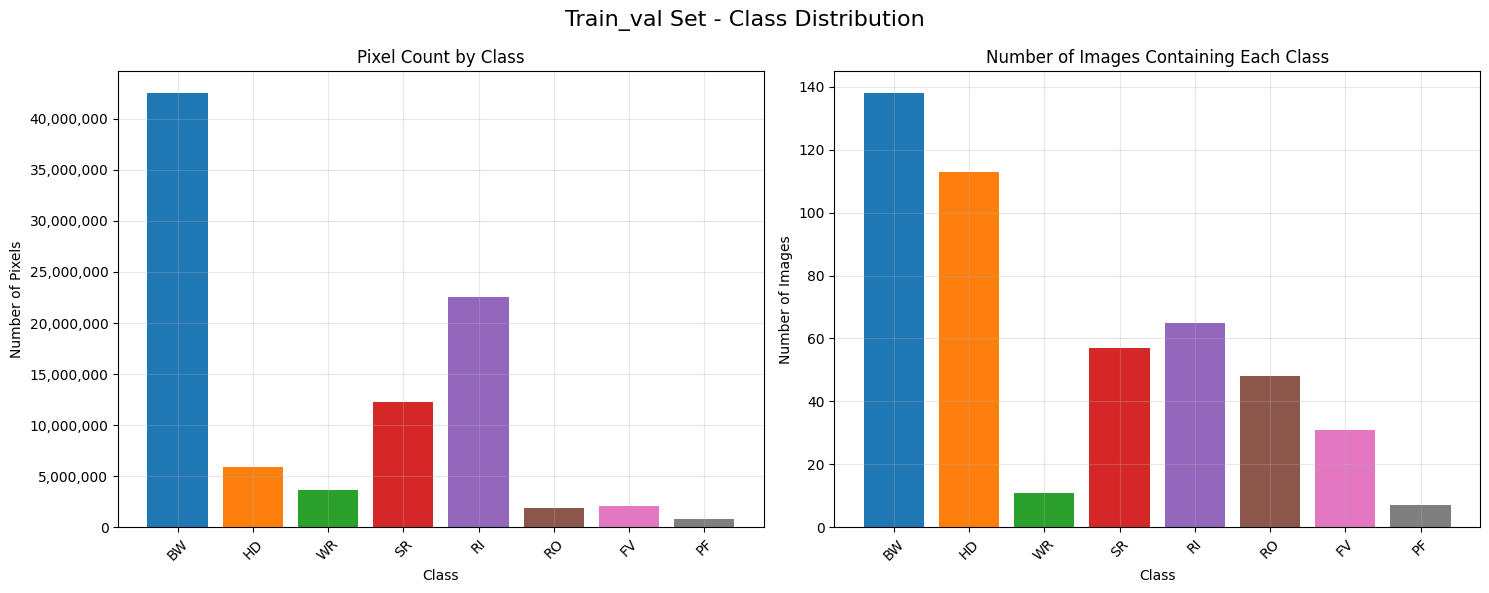


Class percentage distribution (Train_val):
  BW: 45.03%
  HD: 6.28%
  WR: 3.89%
  SR: 12.98%
  RI: 23.92%
  RO: 2.01%
  FV: 2.17%
  PF: 0.81%


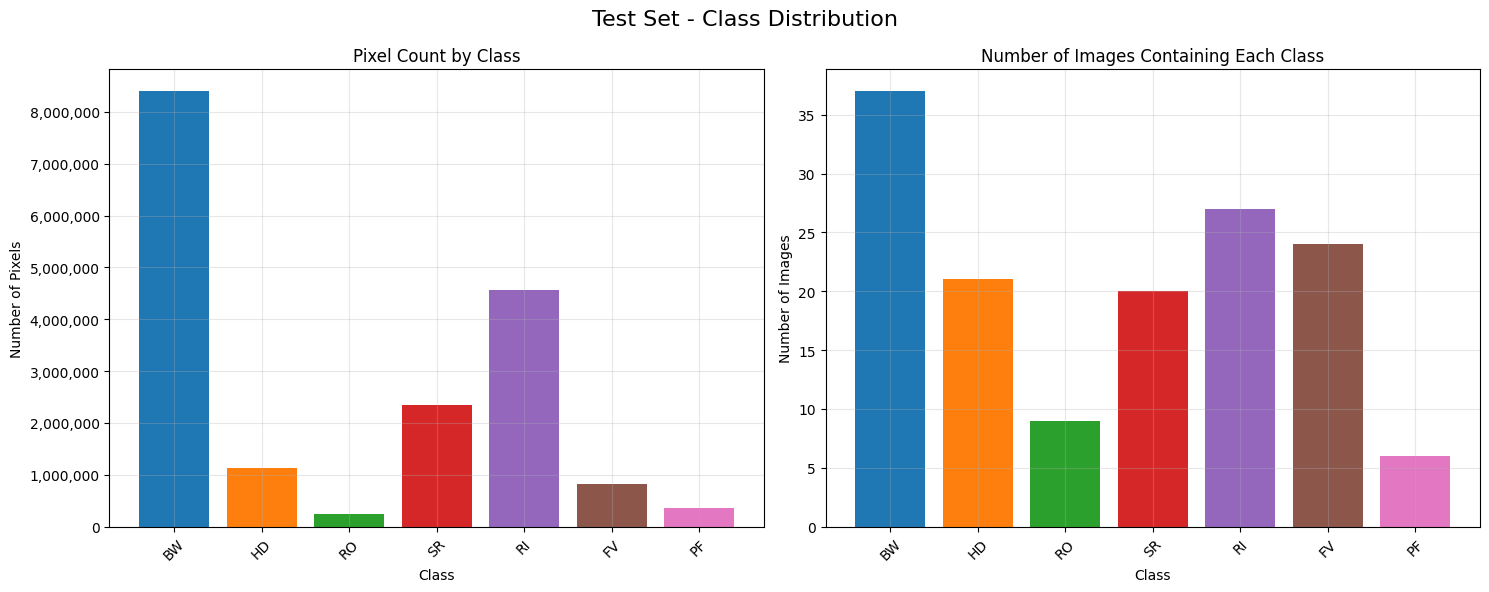


Class percentage distribution (Test):
  BW: 46.96%
  HD: 6.34%
  RO: 1.35%
  SR: 13.14%
  RI: 25.56%
  FV: 4.59%
  PF: 2.04%


In [7]:
def plot_class_distribution(class_stats, split_name):
    """Plot class distribution statistics"""
    if not class_stats or not class_stats['class_pixel_counts']:
        print(f"No class statistics available for {split_name}")
        return

    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    fig.suptitle(f'{split_name} Set - Class Distribution', fontsize=16)

    # Pixel count distribution
    classes = list(class_stats['class_pixel_counts'].keys())
    pixel_counts = list(class_stats['class_pixel_counts'].values())

    axes[0].bar(classes, pixel_counts, color=plt.cm.tab10(range(len(classes))))
    axes[0].set_title('Pixel Count by Class')
    axes[0].set_xlabel('Class')
    axes[0].set_ylabel('Number of Pixels')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3)

    # Format y-axis with commas
    axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

    # Image presence distribution
    presence_counts = [class_stats['class_presence'].get(cls, 0) for cls in classes]

    axes[1].bar(classes, presence_counts, color=plt.cm.tab10(range(len(classes))))
    axes[1].set_title('Number of Images Containing Each Class')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Number of Images')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print percentage distribution
    total_pixels = class_stats['total_pixels']
    print(f"\nClass percentage distribution ({split_name}):")
    for cls in classes:
        pixel_count = class_stats['class_pixel_counts'][cls]
        percentage = (pixel_count / total_pixels * 100) if total_pixels > 0 else 0
        print(f"  {cls}: {percentage:.2f}%")

# Plot distributions
if train_class_stats:
    plot_class_distribution(train_class_stats, 'Train_val')

if test_class_stats:
    plot_class_distribution(test_class_stats, 'Test')


Visualisation of Train_val:


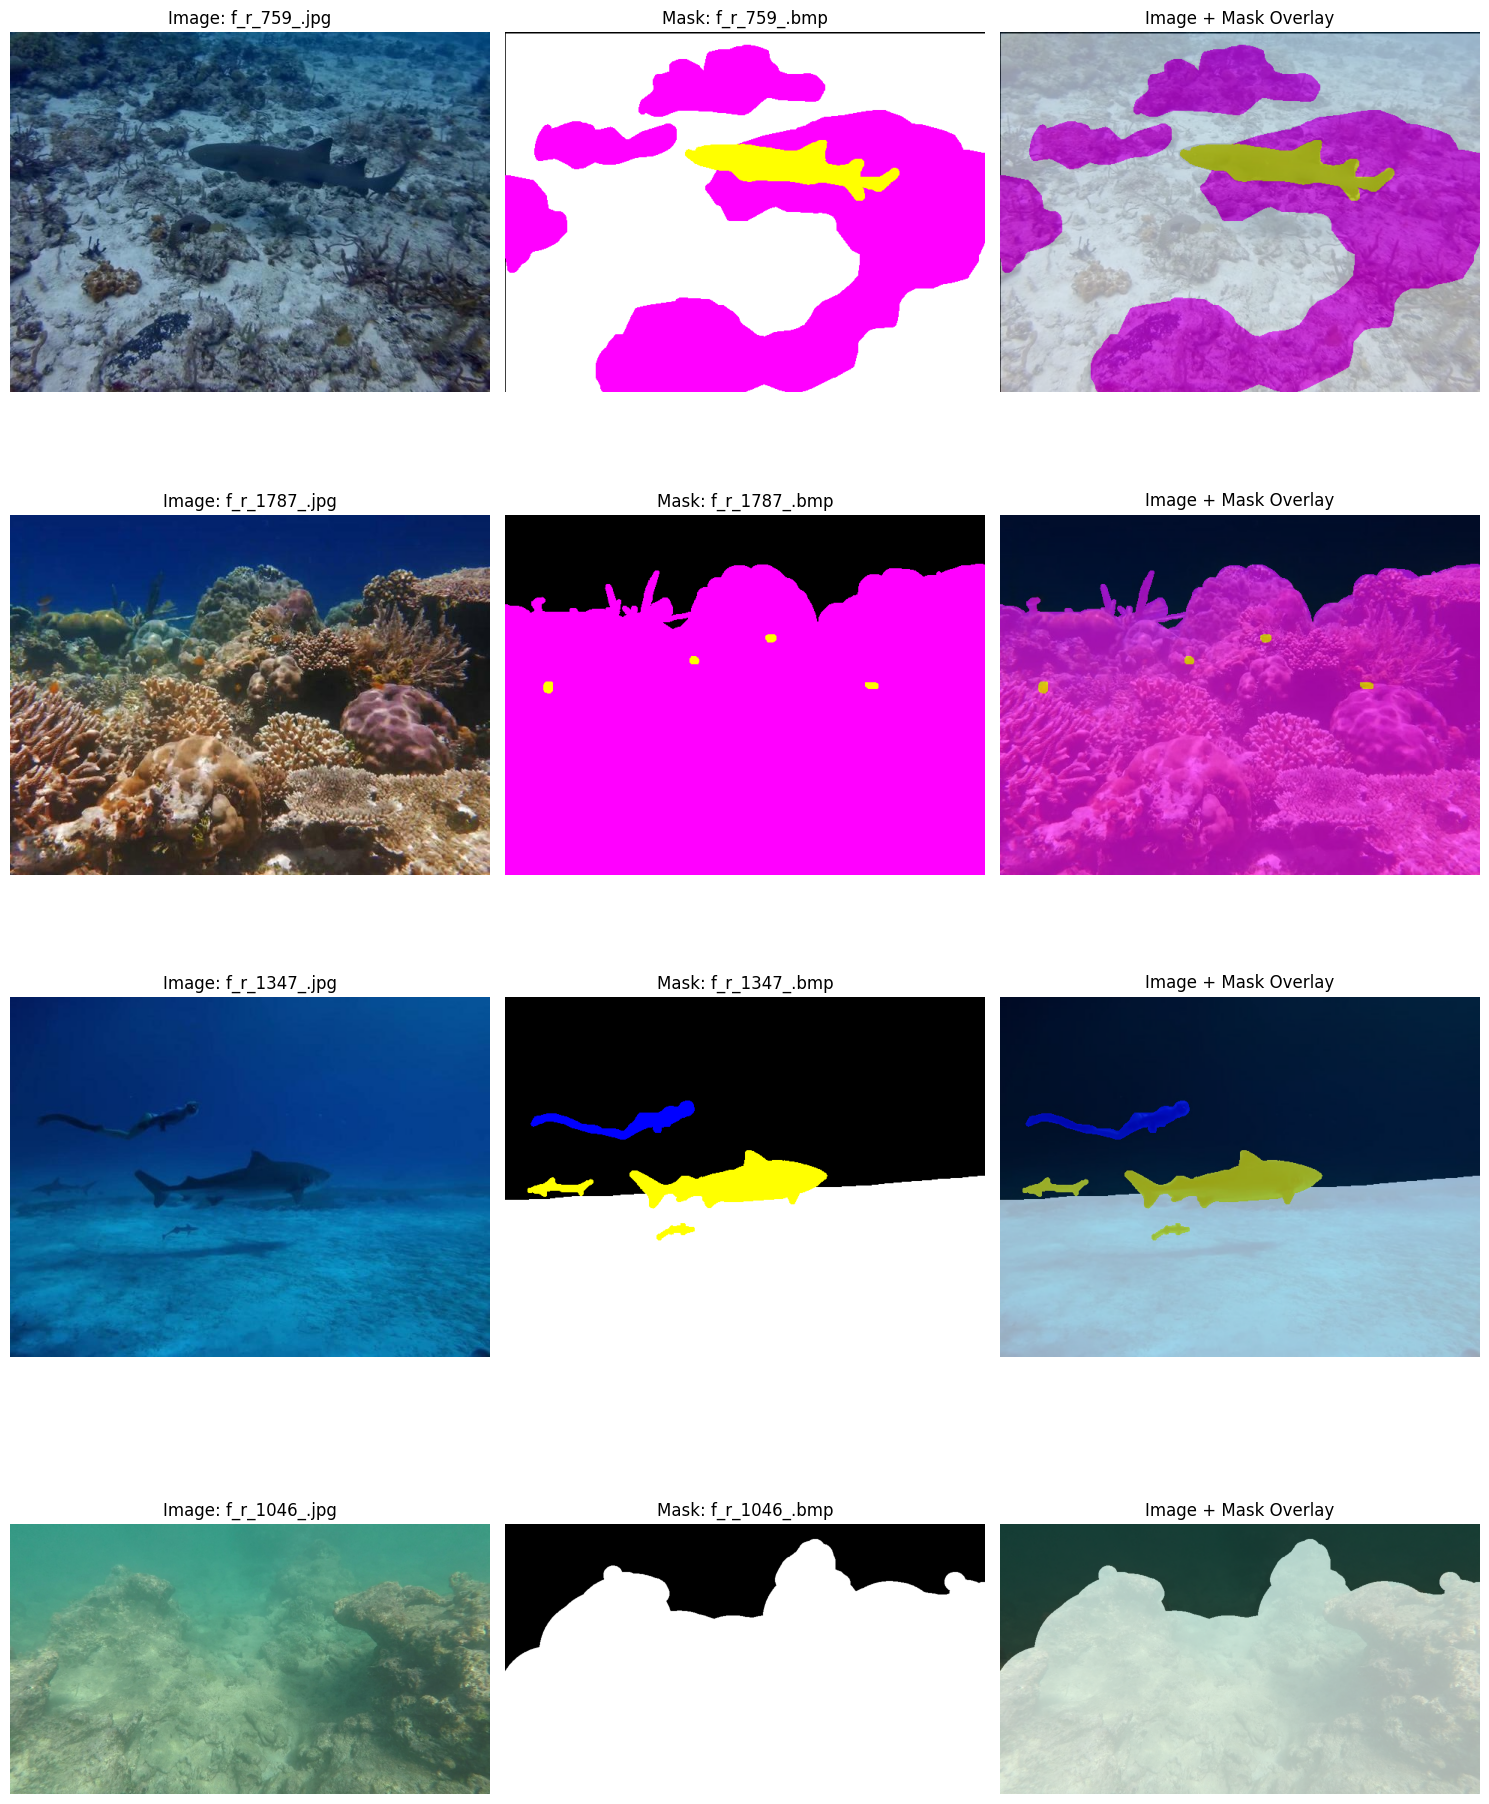


Visualisation of Test:


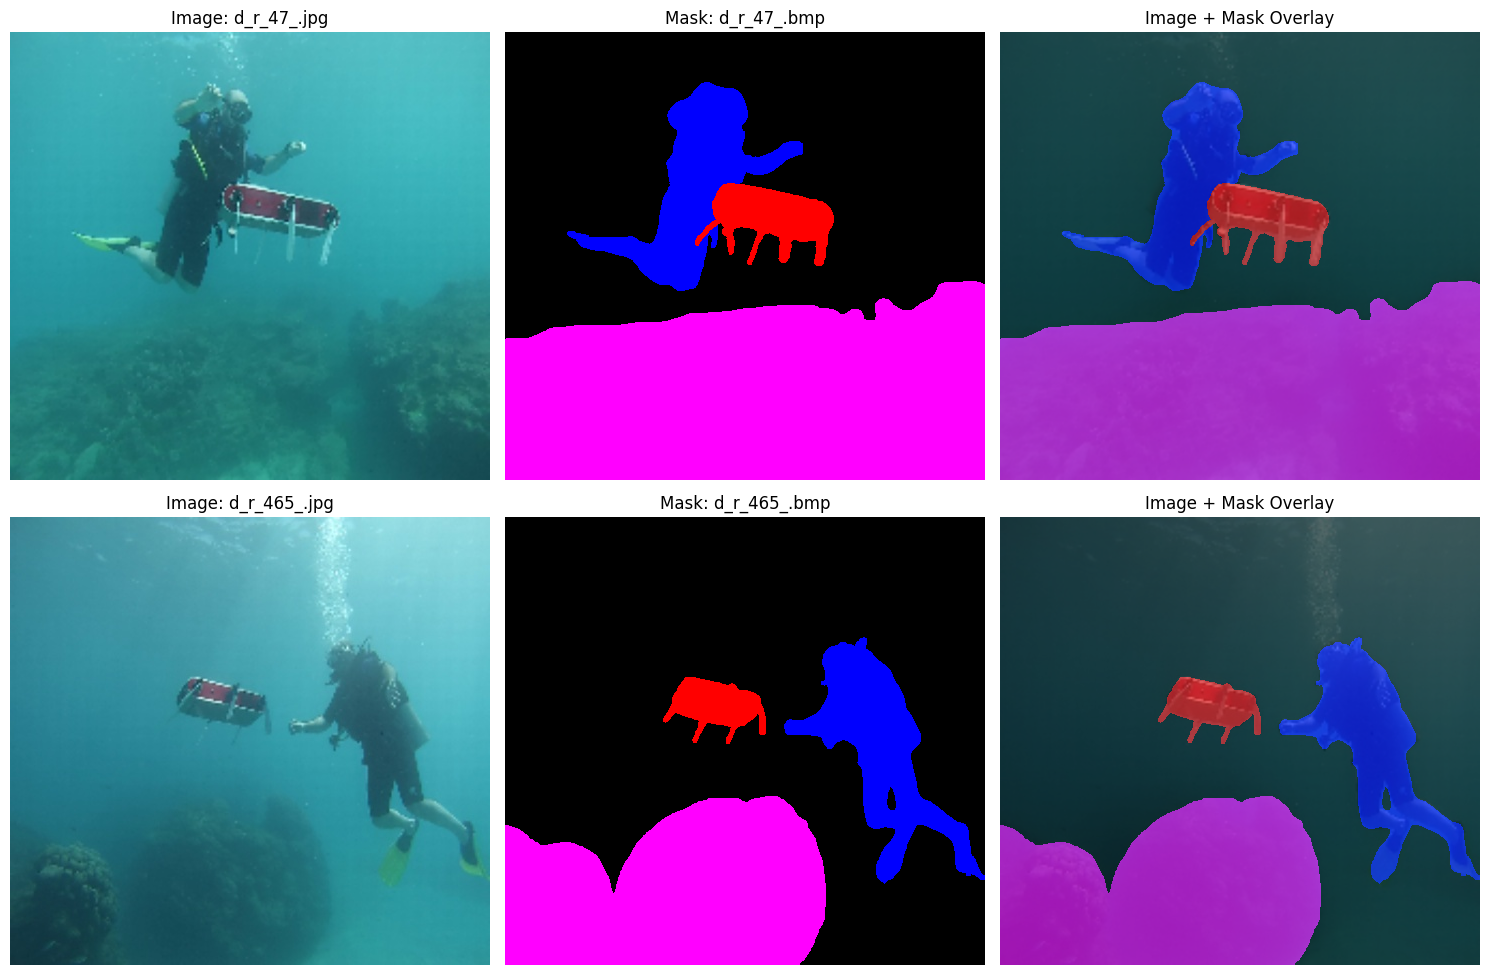

In [18]:
def visualize_samples(split='train_val', num_samples=4, bboxes=None):
    """Visualize sample images with masks, overlays, and optionally bounding boxes"""

    print(f"\nVisualisation of {split.capitalize()}:")
    set_seed(2)

    if split == 'train_val':
        img_path = train_images_path
        mask_path = train_masks_path
    else:
        img_path = test_images_path
        mask_path = test_masks_path

    if not img_path.exists():
        print(f"Path {img_path} does not exist")
        return

    image_files = sorted(list(img_path.glob("*")))

    if len(image_files) == 0:
        print("No image files found")
        return

    # Group bboxes by image file if provided
    bbox_by_image = defaultdict(list)
    if bboxes:
        for bbox in bboxes:
            bbox_by_image[bbox['image_file']].append(bbox)
        print("Including bounding boxes in visualization")

    sample_indices = np.random.choice(len(image_files), min(num_samples, len(image_files)), replace=False)

    # Adjust figure size and columns based on whether bboxes are included
    num_cols = 4 if bboxes else 3
    fig_width = 20 if bboxes else 15
    fig, axes = plt.subplots(num_samples, num_cols, figsize=(fig_width, 5*num_samples))

    # Handle single sample case
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    # Color map for bounding boxes
    if bboxes:
        colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)))
        class_color_map = {class_name: colors[i] for i, class_name in enumerate(class_names)}

    for i, idx in enumerate(sample_indices):
        img_file = image_files[idx]

        try:
            img = Image.open(img_file)
            img_array = np.array(img)

            mask_file = mask_path / (img_file.stem + '.bmp')
            if not mask_file.exists():
                mask_file = mask_path / (img_file.stem + '.png')

            # Column 1: Original Image
            axes[i, 0].imshow(img)
            axes[i, 0].set_title(f'Image: {img_file.name}')
            axes[i, 0].axis('off')

            if mask_file.exists():
                # Column 2: Mask
                mask = Image.open(mask_file)
                mask_array = np.array(mask)
                axes[i, 1].imshow(mask)
                axes[i, 1].set_title(f'Mask: {mask_file.name}')
                axes[i, 1].axis('off')

                # Column 3: Overlay
                overlay = create_image_mask_overlay(img_array, mask_array)
                axes[i, 2].imshow(overlay)
                axes[i, 2].set_title('Image + Mask Overlay')
                axes[i, 2].axis('off')

                # Column 4: Bounding Boxes (only if bboxes provided)
                if bboxes:
                    axes[i, 3].imshow(img)
                    image_bboxes = bbox_by_image.get(img_file.name, [])
                    axes[i, 3].set_title(f'Bounding Boxes ({len(image_bboxes)} objects)')
                    axes[i, 3].axis('off')

                    # Draw bounding boxes
                    for bbox in image_bboxes:
                        x1, y1, x2, y2 = bbox['bbox']
                        class_name = bbox['class_name']

                        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                               linewidth=2,
                                               edgecolor=class_color_map[class_name],
                                               facecolor='none')
                        axes[i, 3].add_patch(rect)

                        axes[i, 3].text(x1, y1-5, f'{class_name}',
                                       bbox=dict(boxstyle="round,pad=0.3",
                                               facecolor=class_color_map[class_name],
                                               alpha=0.7),
                                       fontsize=8, color='white')

                    # Print bbox info
                    if image_bboxes:
                        print(f"\nBounding boxes for {img_file.name}:")
                        for bbox in image_bboxes:
                            print(f"  {bbox['class_name']}: bbox=({bbox['bbox'][0]:.0f},{bbox['bbox'][1]:.0f},{bbox['bbox'][2]:.0f},{bbox['bbox'][3]:.0f}), area={bbox['area']:.0f}")

            else:
                # Handle missing mask
                end_col = num_cols if bboxes else 3
                for col in range(1, end_col):
                    axes[i, col].text(0.5, 0.5, 'No mask found', ha='center', va='center')
                    if col == 1:
                        axes[i, col].set_title('Mask: NOT FOUND')
                    elif col == 2:
                        axes[i, col].set_title('Class Overlay: N/A')
                    elif col == 3:
                        axes[i, col].set_title('Bounding Boxes: N/A')
                    axes[i, col].axis('off')

        except Exception as e:
            print(f"Error loading {img_file.name}: {e}")
            for col in range(num_cols):
                axes[i, col].text(0.5, 0.5, f'Error: {e}', ha='center', va='center')
                axes[i, col].set_title(f'Error: {img_file.name}')
                axes[i, col].axis('off')

    plt.tight_layout()
    plt.show()

def create_image_mask_overlay(img_array, mask_array, alpha=0.6):
    """Create overlay of original image with semi-transparent mask"""
    if len(img_array.shape) != 3 or len(mask_array.shape) != 3:
        return img_array

    if img_array.shape[:2] != mask_array.shape[:2]:
        mask_pil = Image.fromarray(mask_array)
        mask_pil = mask_pil.resize((img_array.shape[1], img_array.shape[0]))
        mask_array = np.array(mask_pil)

    # Using alpha blending: result = (1-alpha) * image + alpha * mask
    overlay = ((1 - alpha) * img_array + alpha * mask_array).astype(np.uint8)

    return overlay

visualize_samples('train_val', num_samples=4)
visualize_samples('test', num_samples=2)


In [10]:
# def check_data_quality(split='train'):
#     """Check for various data quality issues"""
#     print(f"\n=== DATA QUALITY CHECK: {split.upper()} ===")

#     if split == 'train':
#         img_path = train_images_path
#         mask_path = train_masks_path
#     else:
#         img_path = test_images_path
#         mask_path = test_masks_path

#     if not img_path.exists() or not mask_path.exists():
#         print(f"Required paths do not exist")
#         return

#     image_files = sorted(list(img_path.glob("*")))
#     issues = {
#         'empty_masks': [],
#         'corrupted_files': [],
#         'missing_masks': [],
#         'size_mismatches': [],
#         'unusual_values': []
#     }

#     print(f"Checking {len(image_files)} files...")

#     for img_file in image_files:
#         try:
#             # Check image
#             img = Image.open(img_file)
#             img_size = img.size

#             # Find corresponding mask
#             mask_file = mask_path / (img_file.stem + '.bmp')
#             if not mask_file.exists():
#                 mask_file = mask_path / (img_file.stem + '.png')

#             if not mask_file.exists():
#                 issues['missing_masks'].append(img_file.name)
#                 continue

#             # Check mask
#             mask = Image.open(mask_file)
#             mask_array = np.array(mask)
#             mask_size = mask.size

#             # Size mismatch check
#             if img_size != mask_size:
#                 issues['size_mismatches'].append({
#                     'file': img_file.name,
#                     'img_size': img_size,
#                     'mask_size': mask_size
#                 })

#             # Empty mask check (only background)
#             if len(mask_array.shape) == 3:
#                 unique_colors = np.unique(mask_array.reshape(-1, 3), axis=0)
#                 if len(unique_colors) == 1 and np.array_equal(unique_colors[0], [0, 0, 0]):
#                     issues['empty_masks'].append(img_file.name)

#                 # Check for unusual color values
#                 valid_colors = set(tuple(color) for color in class_colors.values())
#                 for color in unique_colors:
#                     if tuple(color) not in valid_colors:
#                         issues['unusual_values'].append({
#                             'file': mask_file.name,
#                             'unusual_color': tuple(color)
#                         })
#                         break

#         except Exception as e:
#             issues['corrupted_files'].append({
#                 'file': img_file.name,
#                 'error': str(e)
#             })

#     # Report issues
#     print(f"Data Quality Report:")
#     print(f"  ✓ Total files checked: {len(image_files)}")
#     print(f"  ⚠️  Empty masks: {len(issues['empty_masks'])}")
#     print(f"  ⚠️  Missing masks: {len(issues['missing_masks'])}")
#     print(f"  ⚠️  Size mismatches: {len(issues['size_mismatches'])}")
#     print(f"  ⚠️  Corrupted files: {len(issues['corrupted_files'])}")
#     print(f"  ⚠️  Unusual color values: {len(issues['unusual_values'])}")

#     # Show examples of issues
#     if issues['empty_masks']:
#         print(f"\nEmpty masks (first 5): {issues['empty_masks'][:5]}")

#     if issues['size_mismatches']:
#         print(f"\nSize mismatches (first 3):")
#         for mismatch in issues['size_mismatches'][:3]:
#             print(f"  {mismatch}")

#     if issues['unusual_values']:
#         print(f"\nUnusual color values (first 3):")
#         for unusual in issues['unusual_values'][:3]:
#             print(f"  {unusual}")

#     return issues

# # Check data quality
# train_quality = check_data_quality('train')
# test_quality = check_data_quality('test')

# Converting Masks to Bounding Boxes (For Object Detection)

In [11]:
def masks_to_bbox(mask_array, class_colors, min_area=100):

  if len(mask_array.shape) != 3:
    return []

  height, width = mask_array.shape[:2]
  bboxes = []

  color_info_dict = {}
  for i, (class_name, color) in enumerate(class_colors.items()):
      color_info_dict[tuple(color)] = {'id': i, 'name': class_name}

  # to ignore background BW skip class 0
  for color, class_info in color_info_dict.items():
    if class_info['id'] == 0:
      continue

    class_mask = np.all(mask_array == color, axis=2)
    if not np.any(class_mask):
      continue

    mask_tensor = torch.from_numpy(class_mask.astype(bool))
    try:
      boxes = masks_to_boxes(mask_tensor.unsqueeze(0))

      if len(boxes) > 0:
        box = boxes[0]
        x1, y1, x2, y2 = box.tolist()
        area = (x2 - x1) * (y2 - y1)
        if area < min_area:
          continue

        bbox_info = {
            'class_id': class_info['id'],
            'class_name': class_info['name'],
            'bbox': [x1, y1, x2, y2],  # [x_min, y_min, x_max, y_max]
            'bbox_normalized': [x1/width, y1/height, x2/width, y2/height],
            'area': area,
            'width': x2 - x1,
            'height': y2 - y1,
            'center': [(x1 + x2) / 2, (y1 + y2) / 2]
        }
        bboxes.append(bbox_info)
    except Exception as e:
      print(f"Error processing class {class_info['name']}: {e}")
      continue

  return bboxes


def convert_dataset(split='train_val', no_files=None):
  print(f"\nConverting masks to bounding boxes for {split.capitalize()} dataset:")

  if split == 'train_val':
      img_path = train_images_path
      mask_path = train_masks_path
  else:
      img_path = test_images_path
      mask_path = test_masks_path

  if not img_path.exists() or not mask_path.exists():
      print(f"Required paths do not exist")
      return []

  image_files = sorted(list(img_path.glob("*")))

  if no_files:
    image_files = image_files[:no_files]

  all_bboxes = []

  for i, img_file in enumerate(image_files):
    try:
      mask_file = mask_path / (img_file.stem + '.bmp')
      if not mask_file.exists():
        mask_file = mask_path / (img_file.stem + '.png')
      mask = np.array(Image.open(mask_file))

      bboxes = masks_to_bbox(mask, class_colors)

      for bbox in bboxes:
        bbox['image_file'] = img_file.name
        bbox['mask_file'] = mask_file.name

      all_bboxes.extend(bboxes)

      #to check remove later
      if (i + 1) % 50 == 0:
        print(f"  Processed {i + 1}/{len(image_files)} files")

    except Exception as e:
      print(f"Error processing {img_file.name}: {e}")

  return all_bboxes


train_bboxes = convert_dataset('train_val')
test_bboxes = convert_dataset('test')



Converting masks to bounding boxes for Train_val dataset:
  Processed 50/1525 files
  Processed 100/1525 files
  Processed 150/1525 files
  Processed 200/1525 files
  Processed 250/1525 files
  Processed 300/1525 files
  Processed 350/1525 files
  Processed 400/1525 files
  Processed 450/1525 files
  Processed 500/1525 files
  Processed 550/1525 files
  Processed 600/1525 files
  Processed 650/1525 files
  Processed 700/1525 files
  Processed 750/1525 files
  Processed 800/1525 files
  Processed 850/1525 files
  Processed 900/1525 files
  Processed 950/1525 files
  Processed 1000/1525 files
  Processed 1050/1525 files
  Processed 1100/1525 files
  Processed 1150/1525 files
  Processed 1200/1525 files
  Processed 1250/1525 files
  Processed 1300/1525 files
  Processed 1350/1525 files
  Processed 1400/1525 files
  Processed 1450/1525 files
  Processed 1500/1525 files

Converting masks to bounding boxes for Test dataset:
  Processed 50/110 files
  Processed 100/110 files


In [12]:
def bbox_distributions (bboxes, split_name):
    print(f"\nBBox Distributions for {split_name.capitalize()} dataset")

    if not bboxes:
        print("No bounding boxes found")
        return

    bbox_df = pd.DataFrame(bboxes)
    print(f"Total bounding boxes: {len(bbox_df)}")
    print(f"Unique images with objects: {bbox_df['image_file'].nunique()}")

    # Size distribution
    print(f"\nSize Categories:")
    bbox_df['size_category'] = pd.cut(bbox_df['area'],
                                     bins=[0, 1000, 5000, 20000, float('inf')],
                                     labels=['Very Small', 'Small', 'Medium', 'Large'])
    size_dist = bbox_df['size_category'].value_counts()
    for category, count in size_dist.items():
        percentage = (count / len(bbox_df)) * 100
        print(f"  {category}: {count} ({percentage:.1f}%)")

    # Class distribution
    print(f"\nClass Distribution:")
    class_dist = bbox_df['class_name'].value_counts()
    for class_name, count in class_dist.items():
        percentage = (count / len(bbox_df)) * 100
        print(f"  {class_name}: {count} ({percentage:.1f}%)")

    # Objects per image distribution
    objects_per_image = bbox_df.groupby('image_file').size()
    print(f"\nObjects per image:")
    print(f"  Mean: {objects_per_image.mean():.2f}")
    print(f"  Median: {objects_per_image.median():.1f}")
    print(f"  Max: {objects_per_image.max()}")

    return bbox_df

# Analyze bounding box statistics
if train_bboxes:
    train_bbox_df = bbox_distributions(train_bboxes, 'train_val')

if test_bboxes:
    test_bbox_df = bbox_distributions(test_bboxes, 'test')


BBox Distributions for Train_val dataset
Total bounding boxes: 3570
Unique images with objects: 1511

Size Categories:
  Large: 3308 (92.7%)
  Medium: 179 (5.0%)
  Small: 64 (1.8%)
  Very Small: 19 (0.5%)

Class Distribution:
  RI: 1014 (28.4%)
  FV: 1012 (28.3%)
  SR: 608 (17.0%)
  HD: 363 (10.2%)
  WR: 261 (7.3%)
  PF: 224 (6.3%)
  RO: 88 (2.5%)

Objects per image:
  Mean: 2.36
  Median: 2.0
  Max: 5

BBox Distributions for Test dataset
Total bounding boxes: 285
Unique images with objects: 110

Size Categories:
  Large: 259 (90.9%)
  Medium: 18 (6.3%)
  Small: 7 (2.5%)
  Very Small: 1 (0.4%)

Class Distribution:
  FV: 66 (23.2%)
  SR: 60 (21.1%)
  RI: 58 (20.4%)
  HD: 42 (14.7%)
  WR: 27 (9.5%)
  PF: 20 (7.0%)
  RO: 12 (4.2%)

Objects per image:
  Mean: 2.59
  Median: 3.0
  Max: 5


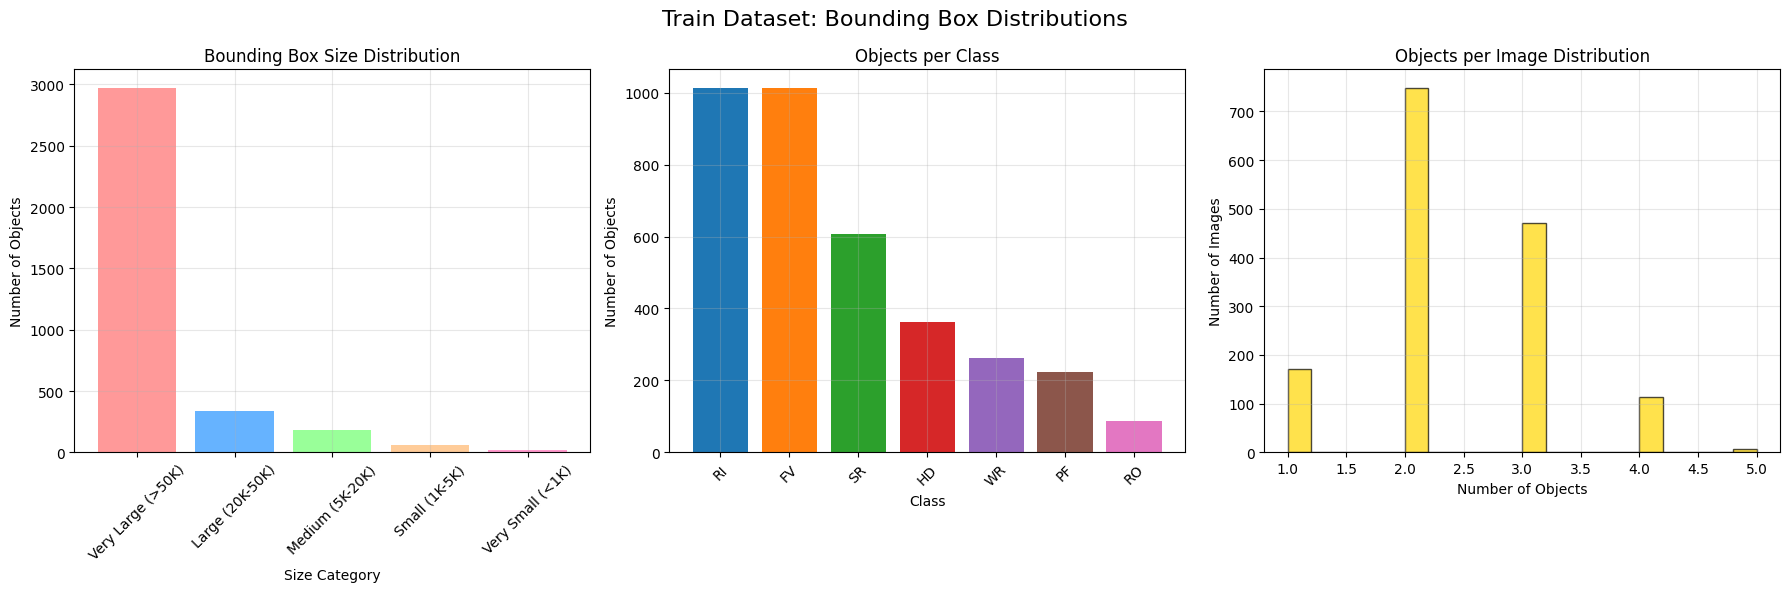

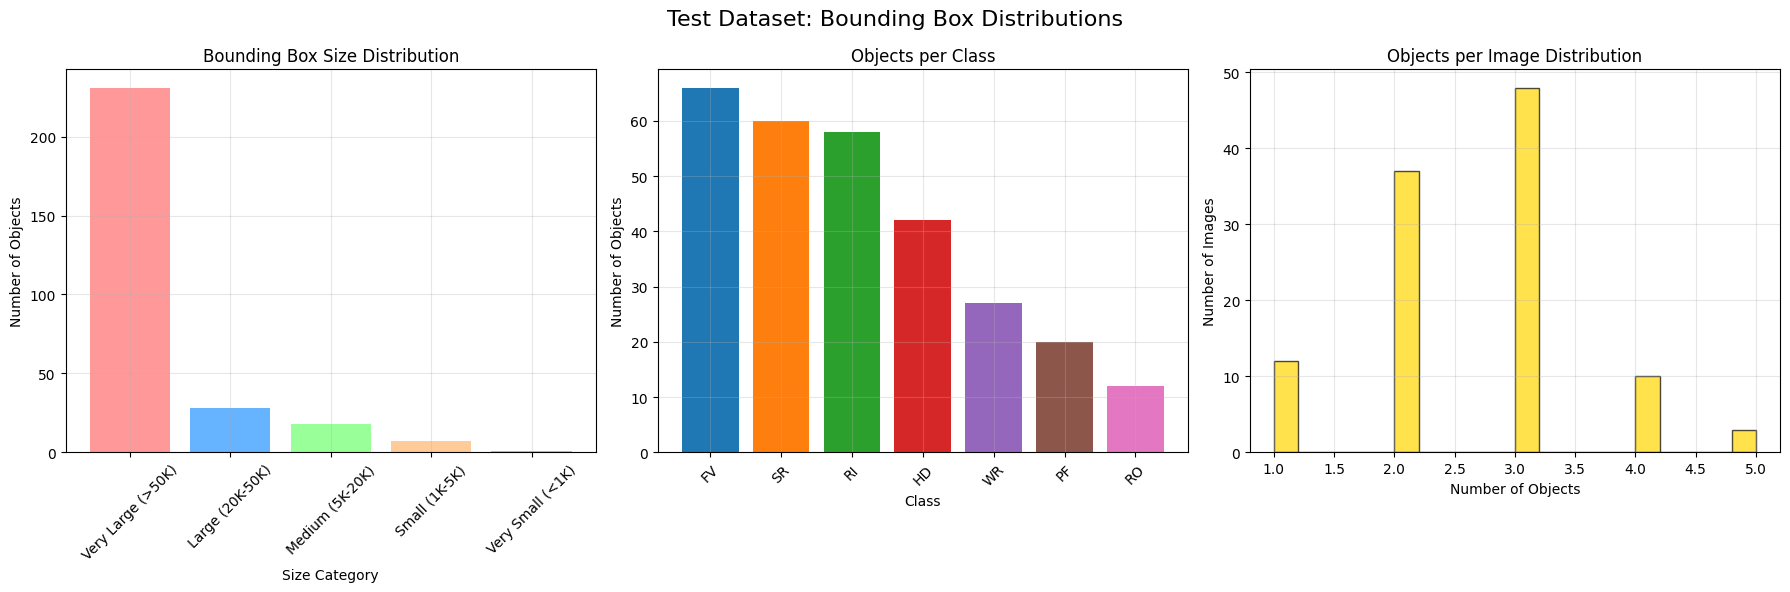

In [13]:
def plot_bbox_statistics(bbox_df, split_name):

    if bbox_df is None or len(bbox_df) == 0:
        print(f"No data to plot for {split_name}")
        return

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'{split_name.capitalize()} Dataset: Bounding Box Distributions', fontsize=16)

    # BBox Size distribution
    bbox_df['size_category'] = pd.cut(bbox_df['area'],
                                     bins=[0, 1000, 5000, 20000, 50000, float('inf')],
                                     labels=['Very Small (<1K)', 'Small (1K-5K)', 'Medium (5K-20K)', 'Large (20K-50K)', 'Very Large (>50K)'])

    size_counts = bbox_df['size_category'].value_counts()
    colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#ff99cc']

    axes[0].bar(range(len(size_counts)), size_counts.values, color=colors[:len(size_counts)])  # Changed from axes[0, 0] to axes[0]
    axes[0].set_title('Bounding Box Size Distribution')
    axes[0].set_xlabel('Size Category')
    axes[0].set_ylabel('Number of Objects')
    axes[0].set_xticks(range(len(size_counts)))
    axes[0].set_xticklabels(size_counts.index, rotation=45)
    axes[0].grid(True, alpha=0.3)

    #Class distribution
    class_counts = bbox_df['class_name'].value_counts()
    axes[1].bar(class_counts.index, class_counts.values, color=plt.cm.tab10(range(len(class_counts))))  # Changed from axes[0, 1] to axes[1]
    axes[1].set_title('Objects per Class')
    axes[1].set_xlabel('Class')
    axes[1].set_ylabel('Number of Objects')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3)

    # Objects per image distribution
    objects_per_image = bbox_df.groupby('image_file').size()
    axes[2].hist(objects_per_image, bins=20, alpha=0.7, color='gold', edgecolor='black')  # Changed from axes[0, 2] to axes[2]
    axes[2].set_title('Objects per Image Distribution')
    axes[2].set_xlabel('Number of Objects')
    axes[2].set_ylabel('Number of Images')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Plot statistics
if 'train_bbox_df' in locals() and len(train_bbox_df) > 0:
    plot_bbox_statistics(train_bbox_df, 'Train')

if 'test_bbox_df' in locals() and len(test_bbox_df) > 0:
    plot_bbox_statistics(test_bbox_df, 'Test')


Visualisation of Train_val:
Including bounding boxes in visualization

Bounding boxes for f_r_759_.jpg:
  RI: bbox=(0,17,639,479), area=295218
  FV: bbox=(240,144,525,224), area=22800
  SR: bbox=(1,2,639,479), area=304326

Bounding boxes for f_r_1787_.jpg:
  RI: bbox=(0,65,639,479), area=264546
  FV: bbox=(51,159,497,237), area=34788

Bounding boxes for f_r_1347_.jpg:
  HD: bbox=(34,139,252,190), area=11118
  FV: bbox=(30,205,429,324), area=47481
  SR: bbox=(0,239,639,479), area=153360

Bounding boxes for f_r_1046_.jpg:
  SR: bbox=(0,30,959,539), area=488131


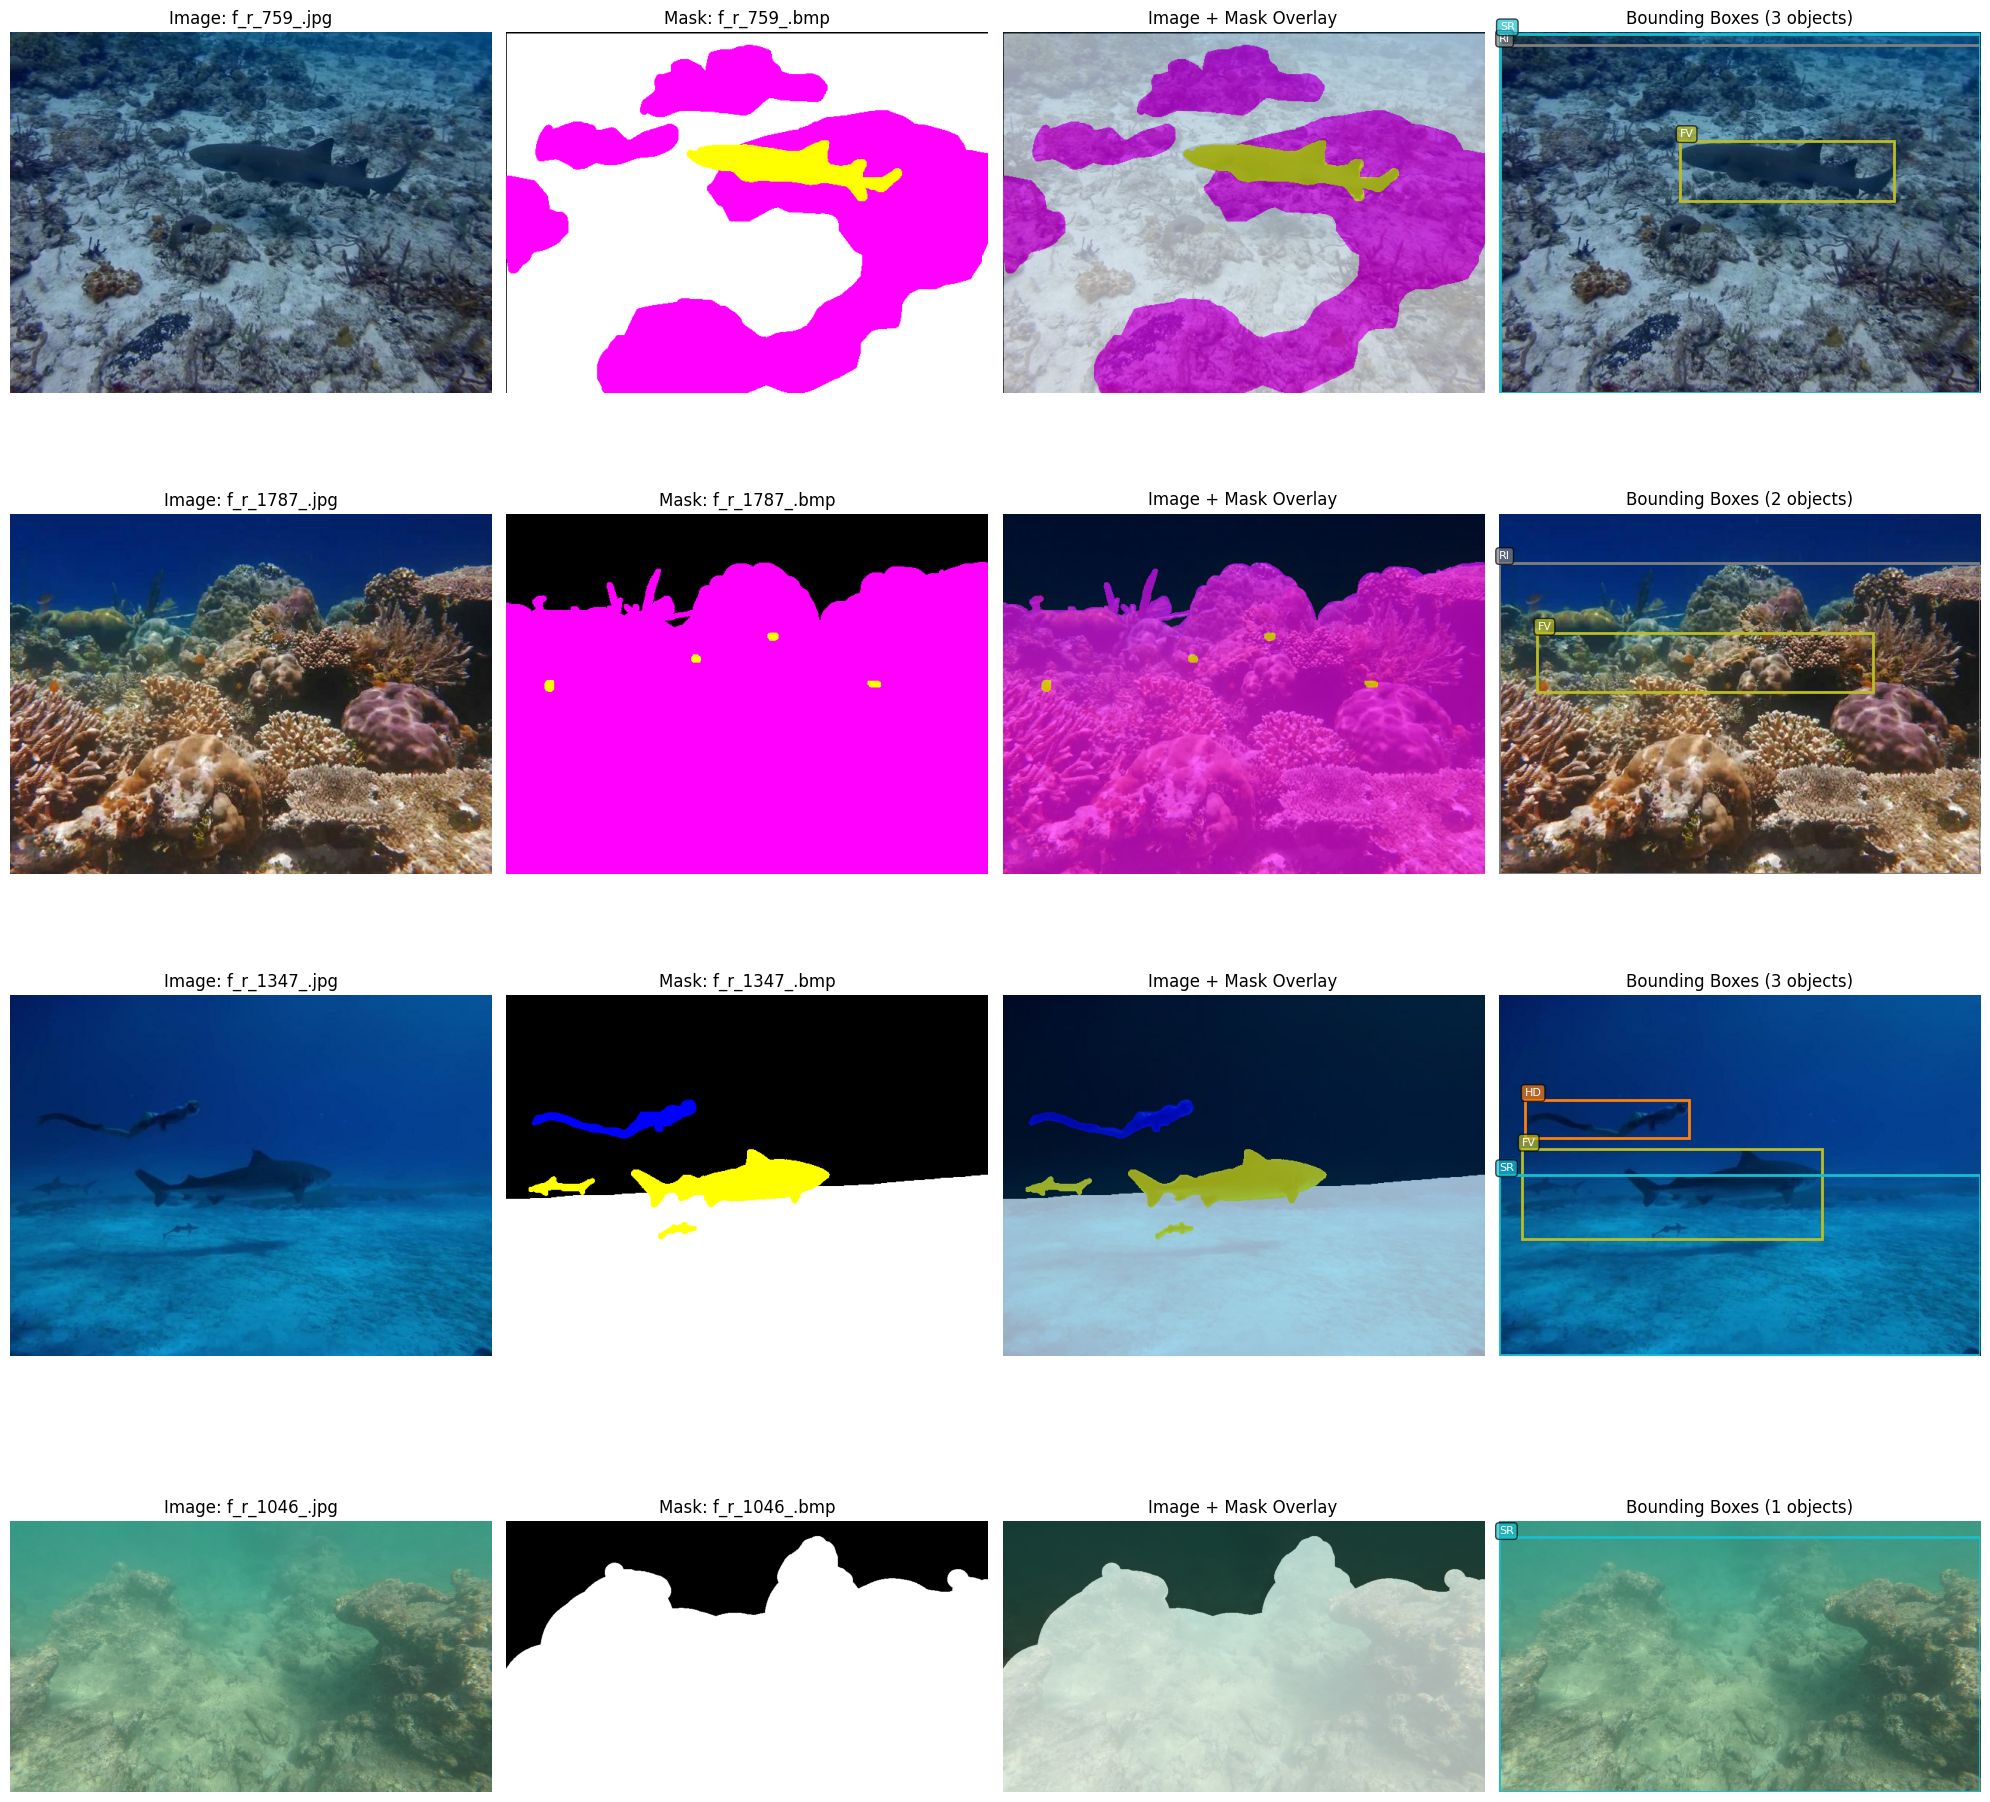


Visualisation of Test:
Including bounding boxes in visualization

Bounding boxes for d_r_47_.jpg:
  HD: bbox=(62,50,297,258), area=48880
  RO: bbox=(190,151,328,233), area=11316
  RI: bbox=(0,249,479,447), area=94842

Bounding boxes for d_r_465_.jpg:
  HD: bbox=(279,120,479,366), area=49200
  RO: bbox=(158,160,260,226), area=6732
  RI: bbox=(0,279,320,447), area=53760


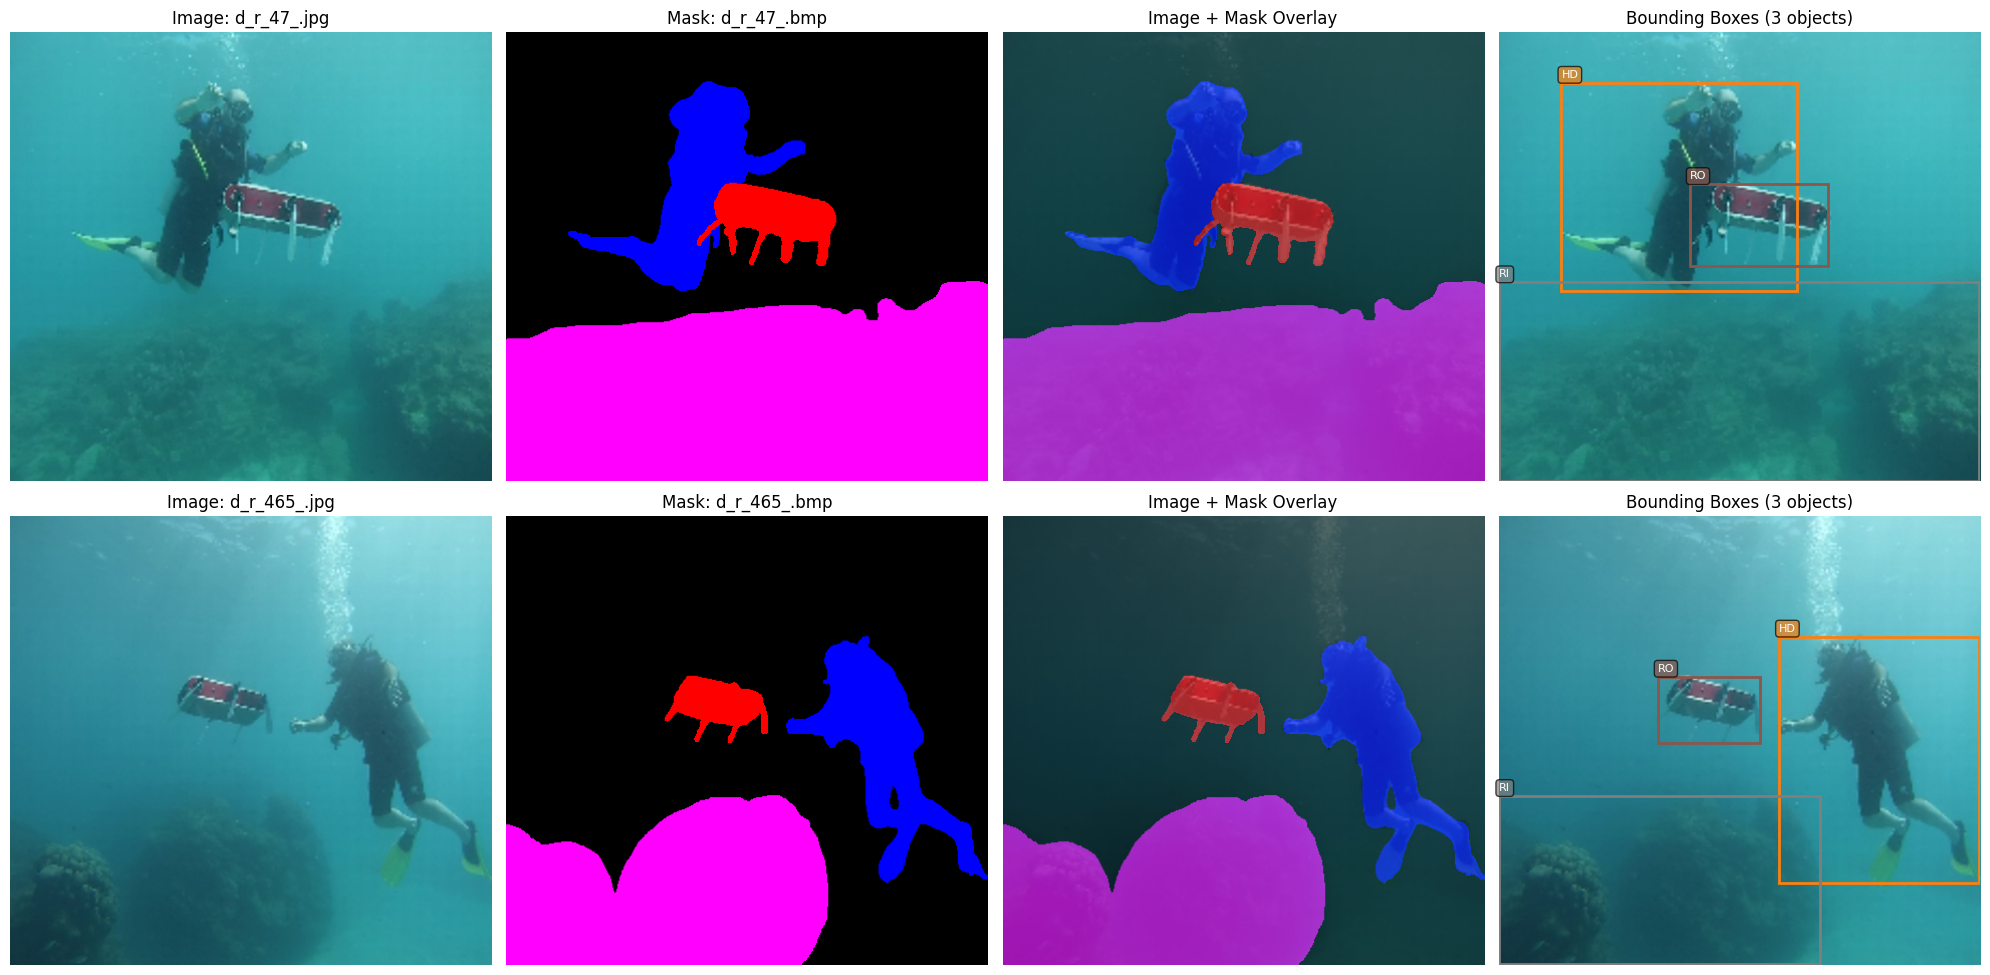

In [16]:
if train_bboxes:
    visualize_samples('train_val', num_samples=4, bboxes=train_bboxes)

if test_bboxes:
    visualize_samples('test', num_samples=2, bboxes=test_bboxes)

# YOLO Config

In [20]:
set_seed(2)

def create_yolo_file(out_path):

  out_path = Path(out_path)
  dirs_to_create = [
      out_path,
      out_path / "images" / "train",
      out_path / "images" / "val",
      out_path / "images" / "test",
      out_path / "labels" / "train",
      out_path / "labels" / "val",
      out_path / "labels" / "test"
      ]
  for pth in dirs_to_create:
    pth.mkdir(parents=True, exist_ok=True)

  return out_path

output_path = "/content/YOLO"
yolo_path = create_yolo_file(output_path)

print(f"Yolo directory created at {yolo_path}")

Yolo directory created at /content/YOLO


In [25]:
def bbox_to_yolo(bbox):

  class_id = bbox['class_id']
  x1_norm, y1_norm, x2_norm, y2_norm = bbox['bbox_normalized']

  x_center = (x1_norm + x2_norm) / 2
  y_center = (y1_norm + y2_norm) / 2
  width = x2_norm - x1_norm
  height = y2_norm - y1_norm

  return f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

def groupby_image(bboxes):
  grouped = defaultdict(list)
  for b in bboxes:
    img_file = b['image_file']
    yolo_annotation = bbox_to_yolo(b)
    grouped[img_file].append(yolo_annotation)

  return grouped

def train_val_split(image_files, ratio = 0.8):
  train_files,val_files = train_test_split(image_files,train_size=ratio,random_state=2,shuffle=True)

  return train_files,val_files

train_yolo_annotations = groupby_image(train_bboxes)
test_yolo_annotations = groupby_image(test_bboxes)

train_val_images = list(train_yolo_annotations.keys())
train_images,val_images = train_val_split(train_val_images)

print(f"No of images for Train YOLO = {len(train_images)}")
print(f"No of images for Validation YOLO = {len(val_images)}")
print(f"Total Train + Val images = {len(train_yolo_annotations)}")
print(f"No of images for Test YOLO = {len(test_yolo_annotations)}")


No of images for Train YOLO = 1208
No of images for Validation YOLO = 303
Total Train + Val images = 1511
No of images for Test YOLO = 110


In [27]:
def create_yolo_format(image_files,annotations_dict,source_imgpath,dest_path,yolo_path):

  dest_image_file = yolo_path/"images"/dest_path
  dest_label_file = yolo_path/"labels"/dest_path

  success = 0; fail = 0; total_obj = 0

  for img_file in image_files:
    try:
      src_img = source_imgpath / img_file
      dst_img = dest_image_file / img_file
      if src_img.exists():
        shutil.copy2(src_img, dst_img)
        label_filename = src_img.stem + '.txt' # YOLO only takes .txt files
        label_path = dest_label_file / label_filename

        img_annotations = annotations_dict.get(img_file, [])
        with open(label_path, 'w') as f:
          for annotation in img_annotations:
            f.write(annotation + '\n')

        success += 1
        total_obj += len(img_annotations)

        #for testing only - remove later
        if success % 100 == 0:
          print(f"Processed {success}/{len(image_files)} files")

      else:
        print(f"Image Not found - f{src_img}")
        fail += 1

    except Exception as e:
      print(f"Error processing {img_file}: {e}")
      fail += 1

  return success,fail,total_obj


def create_dataset_yolo():
  stats = {
      'train': {'images': 0, 'objects': 0},
      'val': {'images': 0, 'objects': 0},
      'test': {'images': 0, 'objects': 0}
  }
  train_success, train_failed, train_objects = create_yolo_format(train_images,train_yolo_annotations,train_images_path,'train',yolo_path)
  stats['train'] = {'images': train_success, 'objects': train_objects}

  val_success, val_failed, val_objects = create_yolo_format(val_images,train_yolo_annotations,train_images_path,'val',yolo_path)
  stats['val'] = {'images': val_success, 'objects': val_objects}

  test_images_list = list(test_yolo_annotations.keys())
  test_success, test_failed, test_objects = create_yolo_format(test_images_list,test_yolo_annotations, test_images_path,'test',yolo_path)
  stats['test'] = {'images': test_success, 'objects': test_objects}

  total_success = train_success + val_success + test_success
  total_failed = train_failed + val_failed + test_failed
  total_objects = train_objects + val_objects + test_objects

  print(f"Total:{total_success} images, {total_objects} objects")
  print(f"Failed:{total_failed} images")

  return stats


dataset_stats = create_dataset_yolo()

Processed 100/1208 files
Processed 200/1208 files
Processed 300/1208 files
Processed 400/1208 files
Processed 500/1208 files
Processed 600/1208 files
Processed 700/1208 files
Processed 800/1208 files
Processed 900/1208 files
Processed 1000/1208 files
Processed 1100/1208 files
Processed 1200/1208 files
Processed 100/303 files
Processed 200/303 files
Processed 300/303 files
Processed 100/110 files
Total:1621 images, 3855 objects
Failed:0 images


In [28]:
def create_yolo_configs(yolo_path, class_names, dataset_stats):
  config = {
      'path': str(yolo_path.absolute()),  # Dataset root dir
      'train': 'images/train',            # Train images (relative to path)
      'val': 'images/val',               # Val images (relative to path)
      'test': 'images/test',             # Test images (relative to path)
      'nc': len(class_names),            # Number of classes
      'names': class_names               # Class names
  }

  config_path = yolo_path / 'data.yaml'
  with open(config_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False)

  classes_path = yolo_path / 'classes.txt'
  with open(classes_path, 'w') as f:
    for i, class_name in enumerate(class_names):
      f.write(f"{i}: {class_name}\n")

  return config_path

yolo_cofig_path = create_yolo_configs(yolo_path,class_names,dataset_stats)
print(f"YOLO Configs created at {yolo_cofig_path}")

YOLO Configs created at /content/YOLO/data.yaml


# Model Training